# Extracting 3-hourly "slices" from the dataset

This takes all "contiguous regions" within the SWE dataset based on a threshold of 0.1 mm / 3h

The following methods are used:

1) `get_storm` : this is a helper function that removes all small objects

2) `calc_features` : this calculates the attributes of each slice (area, length, etc.)

3) `create_slices` : this extracts the footprints of the slices from the 3H SWE data and puts them into a GeoDataFrame

In [16]:
from skimage.measure import regionprops
from scipy.ndimage import label
from skimage.morphology import disk, remove_small_objects
from shapely.geometry import MultiPoint
import geopandas as gpd

feature_list = ['area', 'convex_area', 'eccentricity', 'mean_intensity', 'max_intensity',
                'intensity_variance', 'major_axis_length', 'minor_axis_length',
                'solidity']

def get_storm(prec_grid, thresh, min_size=6):
    r"""Removes all small objects from the 2D grid based on a 
    threshold and minimum pixel size.
    ----------
    prec_grid: (X, Y) ndarray
        Raw data grid from which to remove small objects. This will
        modify the data in place!
    thresh: numerical
        3H rate at which to threshold the input grid
    min_size: int
        The smallest valid size (pixel count) of an object. Default
        value is 6 (6 * 16 = 96 sq. km).
    Returns
    -------
    matches: (X, Y) ndarray
        Labels of objects that are at least `min_size`.
    """
    labels, num_of_labels = label(prec_grid >= thresh)

    labels = remove_small_objects(labels, min_size=min_size)
    
    return labels

def get_features(c_region, c_time, percentile_50, percentile_90):

    features = calc_features(c_region)

    coords = c_region.coords

    polt = MultiPoint(coords).convex_hull

    xmin, xmax = np.min(coords[:, 1]), np.max(coords[:, 1])
    ymin, ymax = np.min(coords[:, 0]), np.max(coords[:, 0])

    features['xmin'] = xmin
    features['xmax'] = xmax
    features['ymin'] = ymin
    features['ymax'] = ymax
    features['coords'] = coords
    features['geometry'] = polt
    features['start_year'] = c_time.year
    features['start_month'] = c_time.month
    features['start_day'] = c_time.day
    features['start_hour'] = c_time.hour
    features['start_time'] = c_time

    y50, x50 = np.where(c_region.intensity_image >= percentile_50)
    y90, x90 = np.where(c_region.intensity_image >= percentile_90)

    features['coords_50p'] = np.array(list(zip(ymin+y50, xmin+x50)))
    features['coords_90p'] = np.array(list(zip(ymin+y90, xmin+x90)))
    
    return features

def calc_features(props, pixel_size=4):
    r"""Calculates select attributes from a given region properties
    object.
    ----------
    props: skimage regionprops
        Formatted data structure for object attributes from 
        scikit-image. 
    pixel_size: integer
        Pixel size / grid spacing in km.
    Returns
    -------
    matches: dict
        A dictionary of selected and modified attributes for a
        given object.
    """
        
    area = props.area * (pixel_size*pixel_size)
    convex_area = props.convex_area * (pixel_size*pixel_size)

    eccentricity = props.eccentricity
    
    mean_intensity = props.mean_intensity
    max_intensity = props.max_intensity
    
    major_axis_length = props.major_axis_length * pixel_size
    minor_axis_length = props.minor_axis_length * pixel_size
    
    ind = np.where(props.intensity_image>0)
    intensity_variance = np.var(props.intensity_image[ind]) 
    
    arr = np.array([area, convex_area, eccentricity, mean_intensity, max_intensity,
                    intensity_variance, major_axis_length, minor_axis_length,
                    props.solidity])

    feature_dict = dict((key, value) for (key, value) in zip(feature_list, arr))
        
    return feature_dict

def create_slices(dataset, rng, mask, thresh, p50=0.46, p90=2.08):
    r"""Transforms a given variable grid into a geopandas
    GeoDataFrame representation of the identified slices.
    ----------
    dataset: xarray
        xarray object of the given data variable
    rng: pandas date_range
        Range in which objects should be extracted from the
        gridded dataset.  Should be in increments of 3 hours.
    mask: ndarray (X, Y)
        Area in which you do not want the function to search 
        for slices (e.g., western U.S.).
    p50: numeric
        50th percentile thresholds to identify pixels coordinates
        that meet or exceed this value. Default 0.46 (mm).
    p90: numeric
        90th percentile thresholds to identify pixels coordinates
        that meet or exceed this value. Default 2.08 (mm).
        
    Returns
    -------
    gdf: GeoDataFrame
        A GeoDataFrame object with the identified slice geometry and 
        their attributes
    """
    
    storm_list = []

    for cur_time in rng:
        
        ds_sub = dataset.sel(Time=cur_time)
        
        prec = ds_sub.SNOW_ACC_NC.values * mask
        
        storms = get_storm(prec, thresh=thresh)
        regions = regionprops(storms, intensity_image=prec)

        for region in regions:
            
            features = get_features(region, cur_time, p50, p90)
            
            storm_list.append(features)
            
        print(cur_time, thresh, len(regions))

    df = pd.DataFrame(storm_list)

    gdf = gpd.GeoDataFrame(df, geometry=df.geometry)
    
    return gdf

# Create some test cases

#### 1. A region with an overall area of 1,440,000 sq. km, a 50th percentile area of 160,000 sq. km, and a 90th percentile area of 25,600.
#### 2. A region with an overall area of 480,000 sq. km, a 50th percentile area of 112,000 sq. km, and a 90th percentile area of 12,800.
#### 3. A region with an overall area of 1 sq. km.
#### 4. A region with an overall area of 6 sq. km.

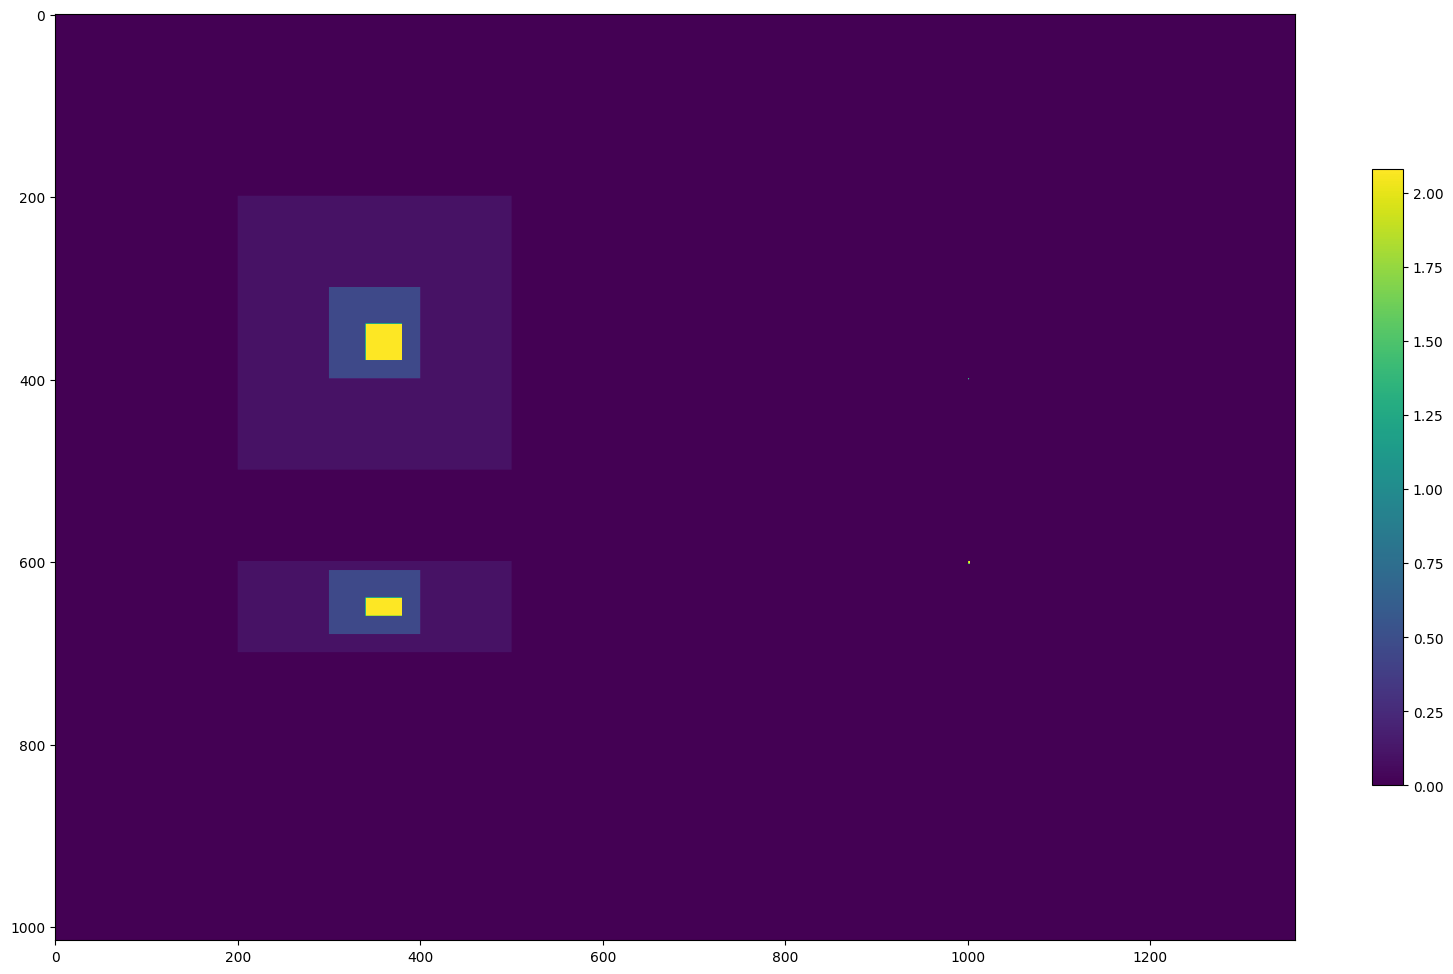

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['figure.figsize'] = 20, 20

test_region = np.zeros(shape=(1015, 1359))

test_region[200:500, 200:500] = 0.1
test_region[300:400, 300:400] = 0.46
test_region[340:380, 340:380] = 2.08

test_region[600:700, 200:500] = 0.1
test_region[610:680, 300:400] = 0.46
test_region[640:660, 340:380] = 2.08

#Too small...
test_region[400:401, 1000:1001] = 2.08

#Too small...
test_region[600:603, 1000:1002] = 2.08

plt.imshow(test_region)
plt.colorbar(shrink=0.4)

# Get only the slices with an area greater than 100 sq. km of 0.1 mm / 3H SWE

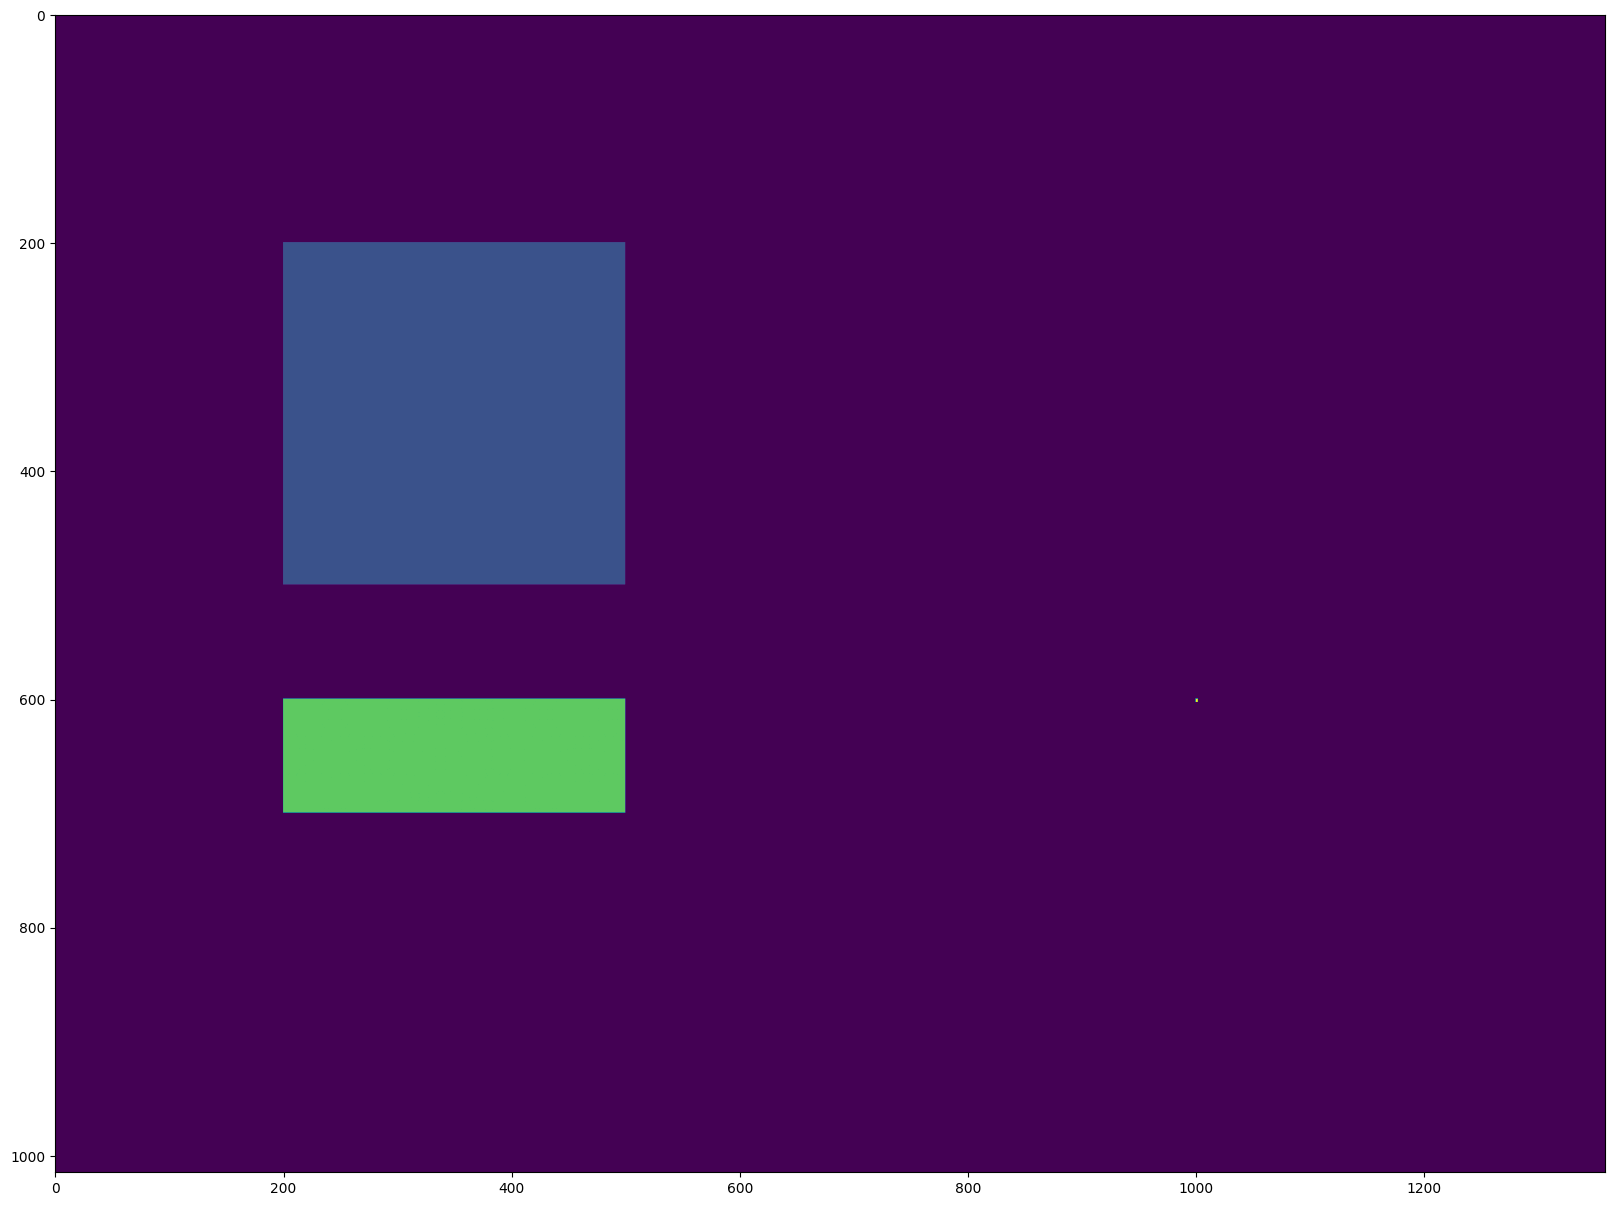

In [5]:
plt.rcParams['figure.figsize'] = 20, 20

storm_labels = get_storm(test_region, 0.1)

plt.imshow(storm_labels)

# Get the attributes of these three storms.

They match up with our expectations above.

In [6]:
import datetime

cur_time = datetime.datetime(1990, 1, 1, 0, 0, 0)

for count, region in enumerate(regionprops(storm_labels, 
                                           intensity_image=test_region)):
    
    tmp_feat = get_features(region, cur_time, 0.46, 2.08)

    print("Storm Number:", count+1)
    print('Area', tmp_feat['area'])
    print('50p Area', 16 * (tmp_feat['coords_50p'].shape[0]))
    print('90p Area', 16 * (tmp_feat['coords_90p'].shape[0]))

Storm Number: 1
Area 1440000.0
50p Area 160000
90p Area 25600
Storm Number: 2
Area 480000.0
50p Area 112000
90p Area 12800
Storm Number: 3
Area 96.0
50p Area 96
90p Area 96


# Example using real data.

Read in the 3H aggregate SWE information for the season 2012-2013

In [7]:
import xarray as xr

ds_3h = xr.open_dataset("../example_data/3H_sum_SNOW_ACC_CTRL_2012-2013.nc")

# Set the time range for one 3h period at 12 UTC on January 1st 2013

Return slice information for this time.

In [8]:
import pandas as pd

drange = pd.date_range(start="2013-01-28 12:00:00", end="2013-01-28 12:00:00", freq='3h')

slices = create_slices(ds_3h, rng=drange, mask=np.ones(shape=(1015, 1359)), thresh=0.1)

2013-01-28 12:00:00 0.1 120


# Display the geographic information.

Since we have information for all "activated" pixels and their locations, we can run through the found slices and show where the identified slices are on the map.

In [9]:
import numpy as np

slice_pos = np.zeros(shape=(1015, 1359))
slice_p50 = np.zeros(shape=(1015, 1359))
slice_p90 = np.zeros(shape=(1015, 1359))

for rid, row in slices.iterrows():
        
    y, x = row.coords[:,0], row.coords[:, 1]
    slice_pos[y, x] = 1

    if len(row.coords_50p) > 0:

        y50, x50 = row.coords_50p[:,0], row.coords_50p[:, 1]
        slice_p50[y50, x50] = 1

        if len(row.coords_90p) > 0:
            y90, x90 = row.coords_90p[:,0], row.coords_90p[:, 1]
            slice_p90[y90, x90] = 1
    

# Plot the SWE data (thresholded at 0.1 mm / 3H) and the countours of the overall area, 50th percentile area, and 90th percentile area.

/Users/jinjiang-macair/anaconda3/envs/future_snow/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


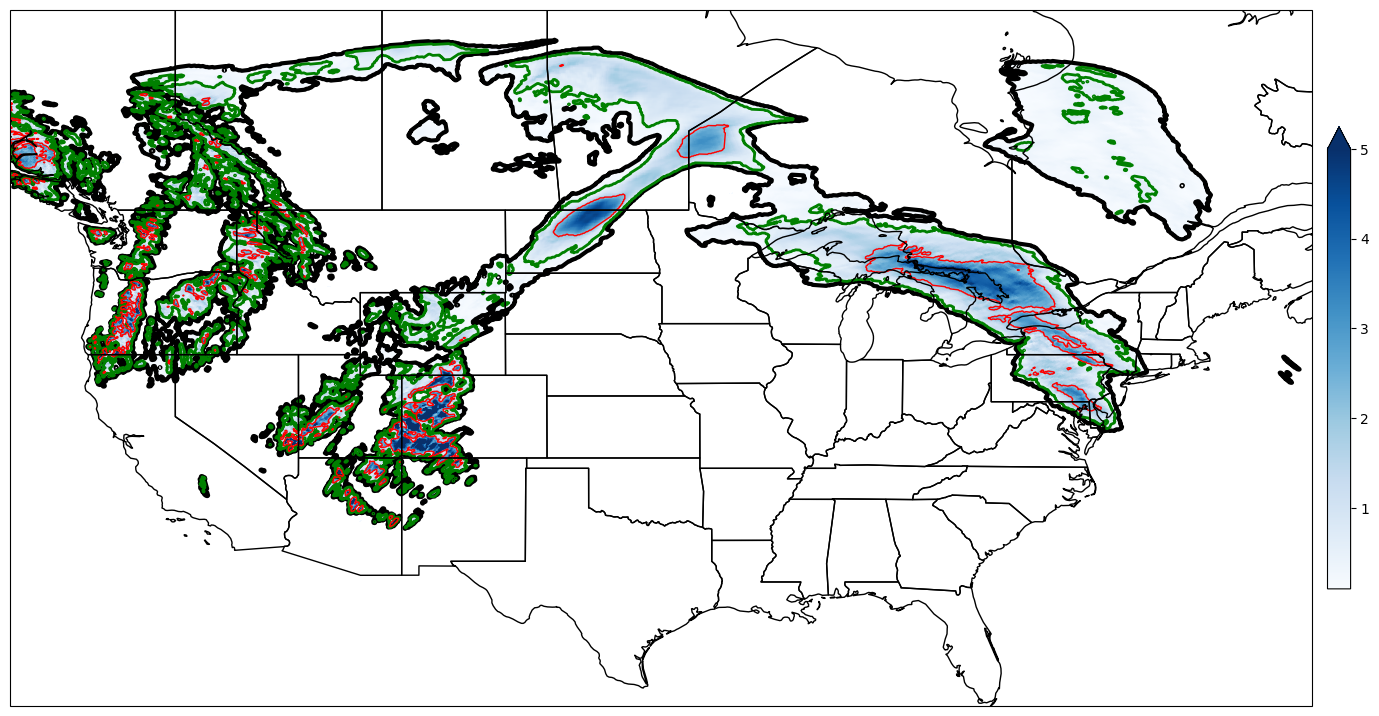

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 20, 20

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 25, 55])

ax.add_feature(cfeature.STATES, zorder=3)

example = ds_3h.sel(Time="2013-01-28 12:00:00")

res = example.SNOW_ACC_NC.values.copy()
res = np.ma.masked_where(res < 0.1, res)

mmp = ax.pcolormesh(example.XLONG, example.XLAT, res, vmin=0.1, vmax=5, cmap='Blues', zorder=2)

ax.contour(example.XLONG, example.XLAT, slice_pos, levels=[0.5], linewidths=3, colors=['k',])
ax.contour(example.XLONG, example.XLAT, slice_p50, levels=[0.5], linewidths=2, colors=['g',])
ax.contour(example.XLONG, example.XLAT, slice_p90, levels=[0.5], linewidths=1, colors=['r',])

plt.colorbar(mmp, ax=ax, shrink=0.3, pad=0.01, extend='max')

# Add more restrictions like applying the study area mask and only considering those slices larger than 100,000 sq. km.

In [11]:
mask = np.load("../example_data/mask.npy")

drange = pd.date_range(start="2013-01-28 12:00:00", end="2013-01-28 12:00:00", freq='3h')

slices = create_slices(ds_3h, rng=drange, mask=mask.copy(), thresh=0.1)

slices[slices['area'] >= 100000]

2013-01-28 12:00:00 0.1 32


,area,convex_area,eccentricity,mean_intensity,max_intensity,intensity_variance,major_axis_length,minor_axis_length,solidity,xmin,...,ymax,coords,geometry,start_year,start_month,start_day,start_hour,start_time,coords_50p,coords_90p
0,1292208.0,2958832.0,0.932043,1.108694,5.481131,1.012288,3241.310501,1174.480078,0.436729,484,...,983,"[[530, 1162], [530, 1163], [531, 1161], [531, ...","POLYGON ((667 484, 650 501, 630 523, 624 531, ...",2013,1,28,12,2013-01-28 12:00:00,"[[535, 1164], [535, 1167], [536, 1163], [536, ...","[[550, 1135], [551, 1134], [551, 1135], [552, ..."
10,391168.0,462320.0,0.856748,0.285062,0.826519,0.013076,1015.585015,523.773491,0.846098,966,...,1002,"[[796, 1165], [796, 1166], [796, 1167], [796, ...","POLYGON ((980 966, 877 973, 807 1097, 804 1112...",2013,1,28,12,2013-01-28 12:00:00,"[[813, 1103], [813, 1104], [814, 1104], [814, ...",[]
31,161424.0,298608.0,0.981658,0.431044,3.051967,0.101054,1261.766105,240.553812,0.540588,300,...,1000,"[[910, 371], [911, 371], [911, 372], [912, 370...","POLYGON ((996 300, 988 303, 983 306, 972 313, ...",2013,1,28,12,2013-01-28 12:00:00,"[[920, 357], [920, 358], [921, 356], [921, 357...","[[943, 339], [943, 340], [943, 341], [943, 342..."


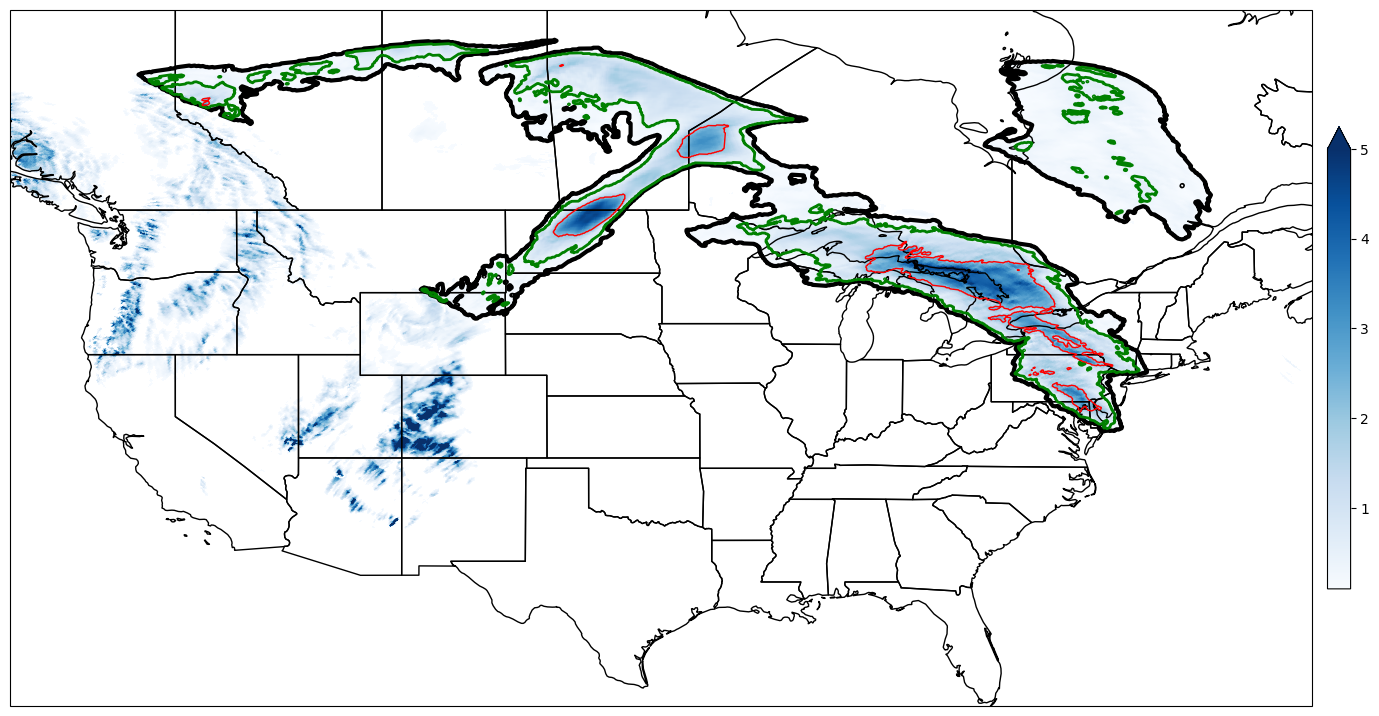

In [12]:
slice_pos = np.zeros(shape=(1015, 1359))
slice_p50 = np.zeros(shape=(1015, 1359))
slice_p90 = np.zeros(shape=(1015, 1359))

for rid, row in slices.iterrows():
        
    if row['area'] >= 100000:
        y, x = row.coords[:,0], row.coords[:, 1]
        slice_pos[y, x] = 1

        if len(row.coords_50p) > 0:

            y50, x50 = row.coords_50p[:,0], row.coords_50p[:, 1]
            slice_p50[y50, x50] = 1

            if len(row.coords_90p) > 0:
                y90, x90 = row.coords_90p[:,0], row.coords_90p[:, 1]
                slice_p90[y90, x90] = 1
                
plt.rcParams['figure.figsize'] = 20, 20

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 25, 55])

ax.add_feature(cfeature.STATES, zorder=3)

example = ds_3h.sel(Time="2013-01-28 12:00:00")

res = example.SNOW_ACC_NC.values.copy()
res = np.ma.masked_where(res < 0.1, res)

mmp = ax.pcolormesh(example.XLONG, example.XLAT, res, vmin=0.1, vmax=5, cmap='Blues', zorder=2)

ax.contour(example.XLONG, example.XLAT, slice_pos, levels=[0.5], linewidths=3, colors=['k',], zorder=4)
ax.contour(example.XLONG, example.XLAT, slice_p50, levels=[0.5], linewidths=2, colors=['g',], zorder=4)
ax.contour(example.XLONG, example.XLAT, slice_p90, levels=[0.5], linewidths=1, colors=['r',], zorder=4)

plt.colorbar(mmp, ax=ax, shrink=0.3, pad=0.01, extend='max')

# Read in the slice data used in this paper

In [13]:
import pickle

ds = pickle.load(open("../example_data/CTRL_2012_2013_010_results.pkl", 'rb'))

ds_sub = ds[(ds.start_time=="2013-01-28 12:00:00") & (ds['area'] >= 100000)]

ds_sub

/var/folders/f0/1x9ky0yd3nj4p68sphk83ngr0000gn/T/ipykernel_15374/2970127287.py:3: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  ds = pickle.load(open("../example_data/CTRL_2012_2013_010_results.pkl", 'rb'))


,area,convex_area,coords,coords_50p,coords_90p,eccentricity,geometry,intensity_variance,major_axis_length,max_intensity,...,solidity,start_day,start_hour,start_month,start_time,start_year,xmax,xmin,ymax,ymin
49636,1292192.0,2958720.0,"[[530, 1162], [530, 1163], [531, 1161], [531, ...","[[535, 1164], [535, 1167], [536, 1163], [536, ...","[[550, 1135], [551, 1134], [551, 1135], [552, ...",0.932052,"POLYGON ((667 484, 650 501, 630 523, 624 531, ...",1.012289,3241.303923,5.481131,...,0.436740,28,12,1,2013-01-28 12:00:00,2013,1186,484,983,530
49646,391168.0,462160.0,"[[796, 1165], [796, 1166], [796, 1167], [796, ...","[[813, 1103], [813, 1104], [814, 1104], [814, ...",[],0.856748,"POLYGON ((980 966, 877 973, 807 1097, 804 1112...",0.013076,1015.585015,0.826519,...,0.846391,28,12,1,2013-01-28 12:00:00,2013,1180,966,1002,796
49667,161440.0,298576.0,"[[910, 371], [911, 371], [911, 372], [912, 370...","[[920, 357], [920, 358], [921, 356], [921, 357...","[[943, 339], [943, 340], [943, 341], [943, 342...",0.981653,"POLYGON ((996 300, 988 303, 983 306, 972 313, ...",0.101048,1261.782757,3.051967,...,0.540700,28,12,1,2013-01-28 12:00:00,2013,623,300,1000,910


# Plot the slice data used in this paper

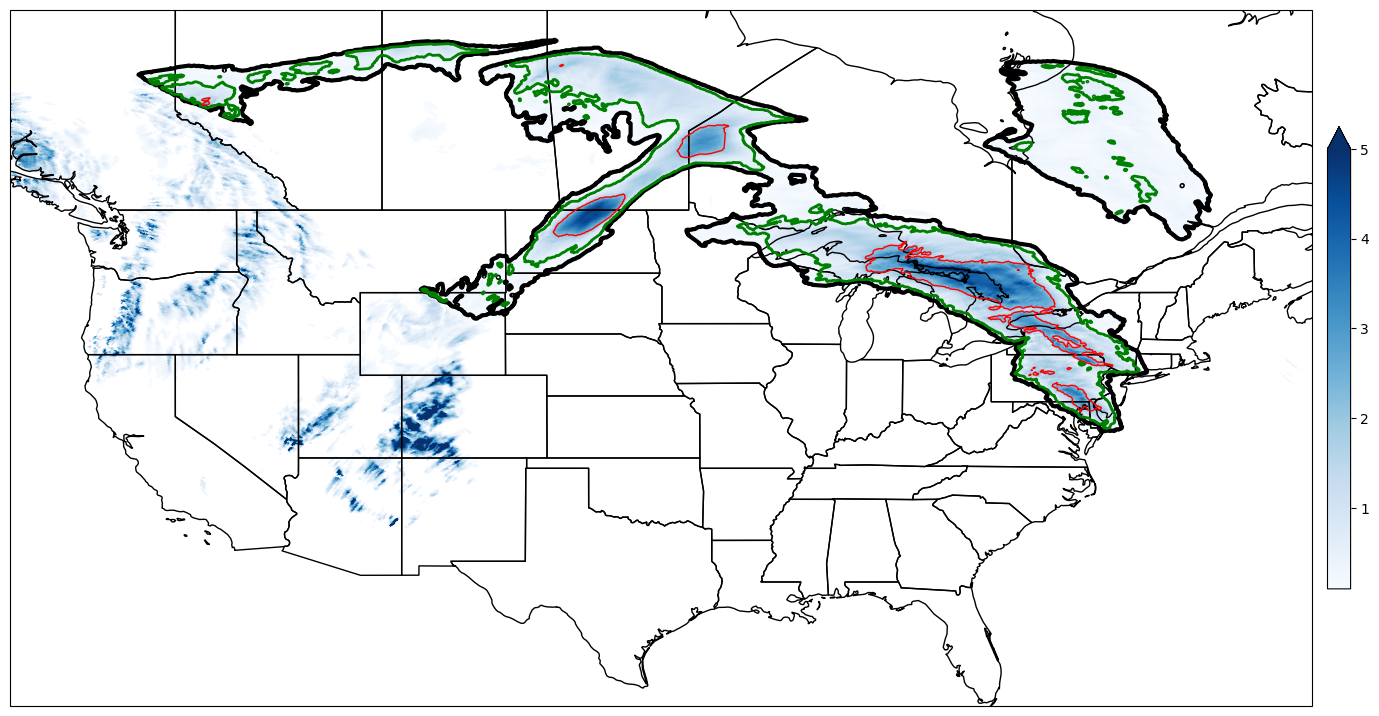

In [14]:
slice_pos_paper = np.zeros(shape=(1015, 1359))
slice_p50_paper = np.zeros(shape=(1015, 1359))
slice_p90_paper = np.zeros(shape=(1015, 1359))

for rid, row in ds_sub.iterrows():
        
    if row['area'] >= 100000:
        y, x = row.coords[:,0], row.coords[:, 1]
        slice_pos_paper[y, x] = 1

        if len(row.coords_50p) > 0:

            y50, x50 = row.coords_50p[:,0], row.coords_50p[:, 1]
            slice_p50_paper[y50, x50] = 1

            if len(row.coords_90p) > 0:
                y90, x90 = row.coords_90p[:,0], row.coords_90p[:, 1]
                slice_p90_paper[y90, x90] = 1
                
plt.rcParams['figure.figsize'] = 20, 20

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 25, 55])

ax.add_feature(cfeature.STATES, zorder=3)

example = ds_3h.sel(Time="2013-01-28 12:00:00")

res = example.SNOW_ACC_NC.values.copy()
res = np.ma.masked_where(res < 0.1, res)

mmp = ax.pcolormesh(example.XLONG, example.XLAT, res, vmin=0.1, vmax=5, cmap='Blues', zorder=2)

ax.contour(example.XLONG, example.XLAT, slice_pos_paper, levels=[0.5], linewidths=3, colors=['k',], zorder=4)
ax.contour(example.XLONG, example.XLAT, slice_p50_paper, levels=[0.5], linewidths=2, colors=['g',], zorder=4)
ax.contour(example.XLONG, example.XLAT, slice_p90_paper, levels=[0.5], linewidths=1, colors=['r',], zorder=4)

plt.colorbar(mmp, ax=ax, shrink=0.3, pad=0.01, extend='max')

# Calculate differences

In [15]:
print(np.sum(slice_pos_paper - slice_pos))

print(np.sum(slice_p50_paper - slice_p50))

print(np.sum(slice_p90_paper - slice_p90))

0.0
0.0
0.0


10/27 - visualize the latitude and longitude of the data to see if it covers western us too

In [17]:
import xarray as xr

ds_3h = xr.open_dataset("../example_data/3H_sum_SNOW_ACC_CTRL_2012-2013.nc")

In [19]:
ds_3h

<xarray.Dataset> Size: 9GB
Dimensions:      (Time: 1697, south_north: 1015, west_east: 1359)
Coordinates:
  * Time         (Time) datetime64[ns] 14kB 2012-10-01 ... 2013-05-01
    XLAT         (south_north, west_east) float32 6MB 18.14 18.15 ... 52.42
    XLONG        (south_north, west_east) float32 6MB -122.9 -122.8 ... -56.95
Dimensions without coordinates: south_north, west_east
Data variables:
    SNOW_ACC_NC  (Time, south_north, west_east) float32 9GB ...
    XTIME        (Time) float32 7kB ...

/Users/jinjiang-macair/anaconda3/envs/future_snow/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


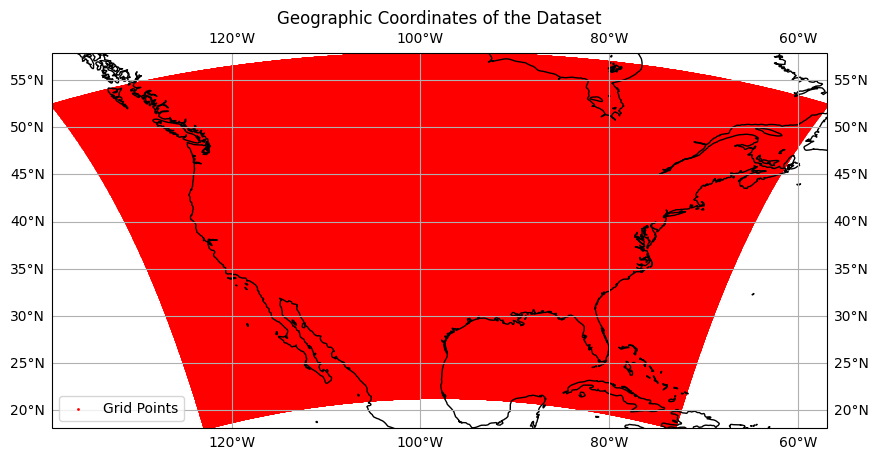

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming ds_3h is your xarray dataset
lon = ds_3h.XLONG.values
lat = ds_3h.XLAT.values

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot the grid points
plt.scatter(lon, lat, s=1, color='red', transform=ccrs.PlateCarree(), label='Grid Points')
plt.legend()
plt.title('Geographic Coordinates of the Dataset')
plt.show()
